In [1]:
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
import pytz
import os

In [2]:
from modules import RiskManagement as RM
from modules import AccountManagement as AM

In [3]:
availabe_accounts = pd.read_csv('account_ids.txt',header=None)
print (availabe_accounts.values)

[['DU1440139']
 ['U2909804']]


In [4]:
account_number = availabe_accounts.values[1][0]

In [5]:
rth = False

In [6]:
if account_number == availabe_accounts.values[1][0]:

    optimal_weights_regularized = pd.read_csv('data/optimal_weights_regularized_sa.csv',index_col = 'asset')
    close = pd.read_csv('data/close_sa.csv', index_col = 'date')
    
elif account_number == availabe_accounts.values[0][0]:
    
    optimal_weights_regularized = pd.read_csv('output/optimal_weights_regularized.csv',index_col = 'asset')
    close = pd.read_csv('data/close.csv', index_col = 'date')

## Portfolio Reading

In [7]:
portfolio = AM().read_positions(subscribe = True, acctCode = account_number)

PositionEnd
Reading Portfolio


In [8]:
portfolio

,Position,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
Symbol,,,,,,
AAPL,10.0,119.540001,1195.40,117.280000,22.60,0.0
ABBV,9.0,97.570000,878.13,99.341111,-15.94,0.0
ALB,-8.0,118.500000,-948.00,117.362287,-9.10,0.0
ALTR,-12.0,48.886299,-586.64,48.685467,-2.41,0.0
AMD,12.0,82.440002,989.28,75.949033,77.89,0.0
AMZN,1.0,3123.000000,3123.00,3035.900000,87.10,0.0
ATVI,14.0,77.699997,1087.80,80.811179,-43.56,0.0
BABA,2.0,265.500000,531.00,285.250000,-39.50,0.0
CAKE,-10.0,34.660000,-346.60,37.499050,28.39,0.0


In [10]:
acc = AM().read_account(subscribe = True, acctCode = account_number)

AccountDownloadEnd. Account: U2909804
Reading Account


In [11]:
all_weights, long, short, grv = RM.portfolio_calculation(portfolio)

In [12]:
long_value = long['marketValue'].sum()
short_value = short['marketValue'].sum()
#print ('Buying Power: {} $'.format(np.round(float(acc.loc['BuyingPower',:].values[0]), 4)))
print ('Gross Market Value: {} $'.format(np.round(grv, 4)))
print (' Long Value: {} $'.format(np.round(long_value,4)))
print (' Short Value: {} $'.format(np.round(short_value,4)))
print (' Net Liquidation: {} $'.format(np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)))
print (' Unrealize PNL: {} $'.format(np.round(portfolio['unrealizedPNL'].sum()),4))
print (' Loan Value: {} $'.format(np.round(float(acc.loc['GrossPositionValue'][0]) - float(acc.loc['EquityWithLoanValue'][0]), 4)))
print ('#####################################')
print ('Leverage Value: {}'.format(np.round(grv/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Long Leverage Value: {}'.format(np.round(long_value/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Short Leverage Value: {}'.format(np.round(np.abs(short_value)/float(acc.loc['EquityWithLoanValue'][0]), 4)))       

Gross Market Value: 37035.49 $
 Long Value: 21731.05 $
 Short Value: -15304.44 $
 Net Liquidation: 21423.85 $
 Unrealize PNL: 632.0 $
 Loan Value: 15611.63 $
#####################################
Leverage Value: 1.7287
 Long Leverage Value: 1.0143
 Short Leverage Value: 0.7144


In [13]:
universe = portfolio.index
long_universe = long.index 
short_universe = short.index 

In [14]:
net_liq = np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)

## Projected portfolio balance

In [15]:
target_leverage = 1.5
grv_target = net_liq * target_leverage
excess_grv = grv_target - grv
print (excess_grv,'$')
marketVal_target = all_weights * grv_target

-4899.715000000007 $


In [16]:
balancing_order = marketVal_target['weights'] - portfolio['marketValue']
df_port = portfolio['marketPrice']
action_balance = pd.DataFrame(index = df_port.index, columns = ['shares'])
action_balance['shares'] = np.round(balancing_order / df_port,2)
to_drop = action_balance[action_balance['shares']==0.0].index
action_balance.drop(to_drop,axis=0,inplace=True)

In [17]:
grv_target

32135.774999999998

In [20]:
val = AM().read_nextvalidid()

NextValidId: 653


## Filtering stocks with significant market value

In [21]:
df_c = pd.DataFrame(data=close[optimal_weights_regularized.index].iloc[-1].values,
                   index = close[optimal_weights_regularized.index].iloc[-1].index,
                   columns = ['close'])
df_c.index.name = 'asset'

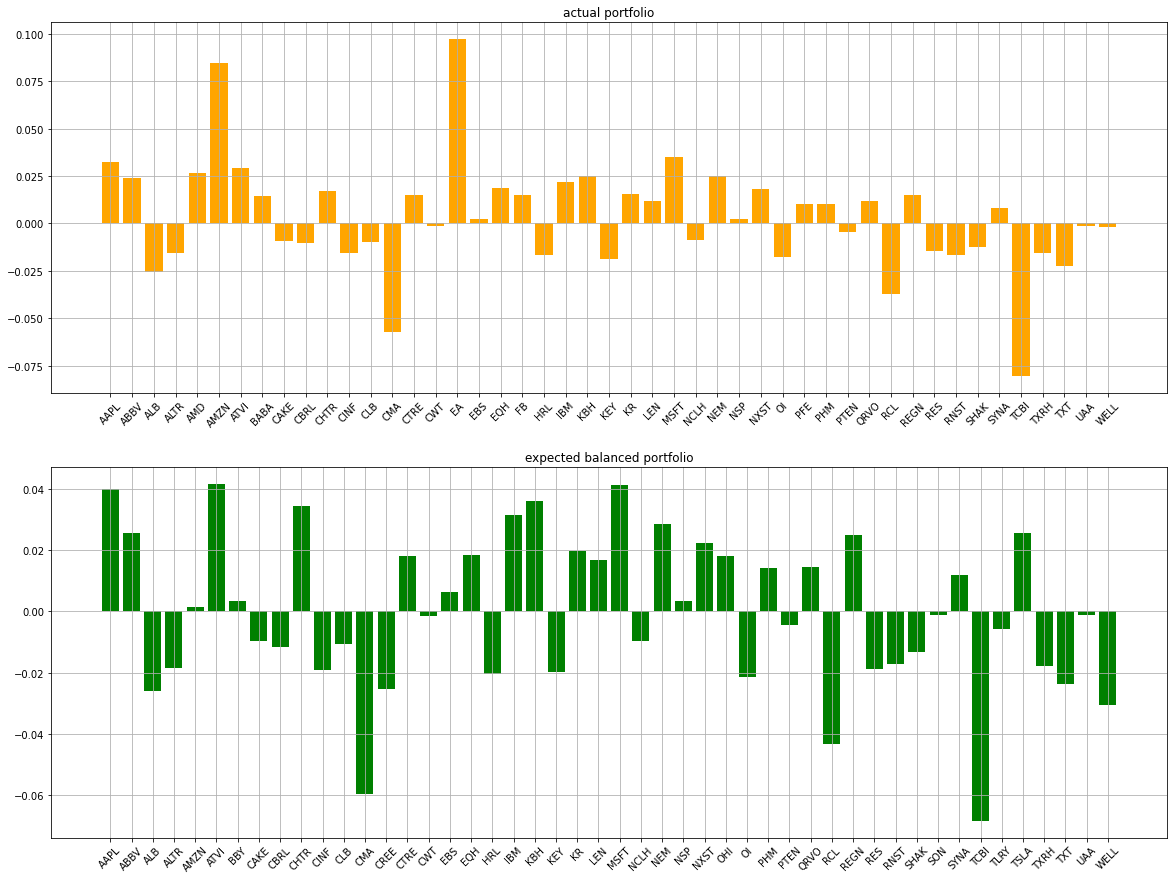

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

x1 = all_weights.index
y1 = all_weights.values.flatten()
axs[0].grid(True)
axs[0].bar(x1, y1, width = 0.8, linewidth = 1, color='orange')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[0].set_title('actual portfolio')

x2 = optimal_weights_regularized.index
y2 = optimal_weights_regularized.values.flatten()
axs[1].grid(True,)
axs[1].bar(x2, y2, width = 0.8, linewidth = 1, color='green')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
axs[1].set_title('expected balanced portfolio')
plt.show()

## Processing data for execution

In [23]:
stock_to_balance = portfolio.index & optimal_weights_regularized.index
stock_to_close = portfolio.index ^ stock_to_balance

In [24]:
df_c_target = df_c.reindex(optimal_weights_regularized.index)
shares_target_float = (optimal_weights_regularized * grv_target)['optimal_weights']/df_c_target['close']

In [25]:
portfolio_shares_float = portfolio['marketValue'] / portfolio['marketPrice']

In [26]:
# Rebalance to optimal weights
action_final = pd.DataFrame(index = shares_target_float.index, columns = ['shares'])

for i in shares_target_float.index:
    
    if (i in stock_to_balance) and (i not in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - portfolio_shares_float[i]
        
    elif (i in stock_to_balance) and (i in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - (portfolio_shares_float[i] + action_balance['shares'][i])

    elif (i in action_balance.index) and (i not in stock_to_balance):
        action_final.loc[i,'shares'] = shares_target_float[i] + action_balance['shares'][i]
    else:
        action_final.loc[i,'shares'] = shares_target_float[i]

In [27]:
# rename columns
portfolio_shares_float = pd.DataFrame(portfolio_shares_float,columns = ['portfolio_shares'],index=portfolio_shares_float.index)
shares_target_float = pd.DataFrame(shares_target_float,columns = ['target_shares_not_balanced'],index=shares_target_float.index)

action_balance.columns = ['balance_lev_shares']
action_final.columns = ['final_action_shares']

In [28]:
# replacing too small actions value with nan value
treshold_long = 1
treshold_short = -1

action_final[(action_final['final_action_shares']>0) & (action_final['final_action_shares']< treshold_long)] = np.nan
action_final[(action_final['final_action_shares']<0) & (action_final['final_action_shares']> treshold_short)] = np.nan
action_final[action_final['final_action_shares']==0.0] = np.nan
action_final.dropna(axis=0,inplace=True)
action_final['final_action_shares'] = pd.to_numeric(action_final['final_action_shares'], errors='coerce')

In [29]:
action_conc = pd.concat([portfolio_shares_float,
                         action_balance,
                         shares_target_float,
                         action_final],axis=1)

In [30]:
isna_df = action_conc.isna()
for i in action_conc.index:
    if (isna_df.loc[i]['final_action_shares'] == True) & (isna_df.loc[i]['target_shares_not_balanced'] == False) :
        action_conc.drop(i, inplace = True)

In [31]:
action_conc.head(50)

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares
AAPL,10.000000,-1.32,11.384772,2.704772
ABBV,9.000000,-1.19,9.654555,1.844555
ALB,-8.000000,1.06,-8.920257,-1.980257
ALTR,-12.000090,1.61,-12.996443,-2.606353
AMD,12.000000,-1.59,NaN,NaN
ATVI,14.000001,-1.84,17.158155,4.998154
BABA,2.000000,-0.27,NaN,NaN
CAKE,-10.000000,1.28,-10.603761,-1.883761
CINF,-6.999942,0.92,-7.675003,-1.595061
CLB,-20.000000,2.64,-21.307736,-3.947736


## Executing on TWS

In [29]:
op = AM.cancel_openorders()

open order ended


In [30]:
# closing positions not in shares target
if not stock_to_close.empty:
    next_order_id = AM.closing_positions(stock_to_close = stock_to_close,
                                              portfolio = portfolio , 
                                              order_id = val,
                                              ordersPriority = 'Patient',
                                              transmit = True)
else:
    print ('There is no stock to close...')
    next_order_id = val

app is running ...
closing 15 positions which are not present in action
closing position for AGNC is: 58 
closing position for ALL is: 59 
closing position for AMD is: 12 
closing position for AON is: 5 
closing position for ARE is: 17 
closing position for BABA is: 2 
closing position for D is: 1 
closing position for DD is: 17 
closing position for EA is: 30 
closing position for FB is: 2 
closing position for ISRG is: 1 
closing position for PANW is: 5 
closing position for PFE is: 10 
closing position for SWK is: 11 
closing position for WDAY is: 3 


In [31]:
action_final = action_final.astype('int')
AM.placing_final_orders(action_final=action_final, 
                             order_id = next_order_id,
                             ordersPriority = 'Patient',
                             transmit = True)

buy order quantity placed for AAPL is: 10 
buy order quantity placed for ABBV is: 9 
sell order quantity placed for ALB is: 8 
sell order quantity placed for ALTR is: 12 
sell order quantity placed for AMZN is: 1 
buy order quantity placed for ATVI is: 4 
sell order quantity placed for CAKE is: 10 
sell order quantity placed for CBRL is: 3 
buy order quantity placed for CHTR is: 1 
sell order quantity placed for CINF is: 7 
sell order quantity placed for CLB is: 20 
sell order quantity placed for CMA is: 44 
sell order quantity placed for CREE is: 11 
buy order quantity placed for CTRE is: 29 
sell order quantity placed for CWT is: 1 
buy order quantity placed for EBS is: 1 
buy order quantity placed for EQH is: 29 
sell order quantity placed for HRL is: 12 
buy order quantity placed for IBM is: 7 
buy order quantity placed for KBH is: 28 
sell order quantity placed for KEY is: 48 
buy order quantity placed for KR is: 18 
buy order quantity placed for LEN is: 6 
buy order quantity plac

In [32]:
if rth:
    print ('we are in regular trading hours...')
    open_orders_all = AM.get_openorders()
    if list(open_orders_all.values) == []:
        portfolio = AM.read_positions(subscribe = True, acctCode = account_number)
        not_executed = portfolio.index ^ action_final.index
        if list(not_executed)==[]:
            print ('all orders are executed')
        else:
            print ('some orders still not executed')
            print (not_executed)
    
else:
    print ('we are not in regular trading hours...')
    open_orders_all = AM.get_openorders()    
    not_executed = open_orders_all.index ^ action_conc.index
    
    if list(not_executed)==[]:
        print ('all orders are placed and ready to be executed...')
    
    else:
        print (list(not_executed))
        print ('The orders above are not placed. please check manually or retry to run the functions...')
    
    table = pd.concat([action_conc, open_orders_all[['open orders']]],axis=1)

we are not in regular trading hours...
['AAPL', 'ABBV', 'AGNC', 'ALB', 'ALL', 'ALTR', 'AMD', 'AMZN', 'AON', 'ARE', 'ATVI', 'BABA', 'CAKE', 'CBRL', 'CHTR', 'CINF', 'CLB', 'CMA', 'CREE', 'CTRE', 'CWT', 'D', 'DD', 'EA', 'EBS', 'EQH', 'FB', 'HRL', 'IBM', 'ISRG', 'KBH', 'KEY', 'KR', 'LEN', 'MSFT', 'NCLH', 'NEM', 'NSP', 'NXST', 'OHI', 'OI', 'PANW', 'PFE', 'PHM', 'PTEN', 'QRVO', 'RCL', 'REGN', 'RES', 'RNST', 'SHAK', 'SYNA', 'TCBI', 'TLRY', 'TSLA', 'TXRH', 'TXT', 'UAA', 'WDAY', 'WELL']
The orders above are not placed. please check manually or retry to run the functions...


In [33]:
table

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares,open orders
AGNC,-58.000001,-11.25,NaN,NaN,NaN
ALL,59.000000,11.36,NaN,NaN,NaN
AMD,12.000000,2.32,NaN,NaN,NaN
AMZN,1.000000,0.19,0.013073,-1.176927,NaN
AON,-5.000025,-0.96,NaN,NaN,NaN
...,...,...,...,...,...
TLRY,NaN,NaN,-35.008881,-35.008881,NaN
TSLA,NaN,NaN,1.918137,1.918137,NaN
TXRH,NaN,NaN,-8.194729,-8.194729,NaN
TXT,NaN,NaN,-20.544959,-20.544959,NaN


## Commission report of last realized trades

In [30]:
com = AM.commission_report(acctCode = account_number, time= '')

In [31]:
com

,ticker,shares,action,price,marketValue,RealizedPNL,commission
time,,,,,,,
2020-10-06 13:11:45,JCI,100,BOT,42.42,4242,-216.021,0.670257
2020-10-06 13:11:45,JCI,100,BOT,42.42,4242,-216.021,0.670257
2020-10-06 13:11:45,JCI,5,BOT,42.42,212.1,-10.8011,0.033513
2020-10-06 13:11:53,EL,19,BOT,220.19,4183.61,-278.531,0.331257
2020-10-06 13:12:00,DE,49,BOT,229.76,11258.2,-801.009,0.301257
2020-10-06 13:12:06,SQ,10,BOT,180.91,1809.1,-293.106,0.340257
2020-10-06 13:12:13,ES,100,SLD,91.03,9103,1253.29,0.463334
2020-10-06 13:12:13,ES,100,SLD,91.03,9103,1253.29,0.463334
2020-10-06 13:12:15,VLO,100,SLD,44.15,4415,17.5189,0.359729


In [32]:
execution_date = com.index[-1]

In [33]:
RealizedPNL = np.round(pd.to_numeric(com.loc[slice(execution_date)]['RealizedPNL'], errors='coerce').sum(),2)
#Total_Realized_Return = np.round((RealizedPNL/net_liq)*100,2)
print ('Report for {}:'.format(execution_date.date()))
print (' Market Value: {} $'.format(np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)))
print (' Total Commission: {} $'.format(np.round(com.loc[slice(execution_date)]['commission'].sum(),2)))
print (' Total Realized PNL: {} $'.format(RealizedPNL))  
#print (' Total Realized Return: {} %'.format(Total_Realized_Return))  


Report for 2020-10-06:
 Market Value: 460891.62 $
 Total Commission: 69.68 $
 Total Realized PNL: 2459.23 $


In [34]:
rootdir = 'data'
if account_number == availabe_accounts.values[0][0]:
    for subdir, dirs, files in os.walk(rootdir):
        for item in files:

            if item.endswith('.csv') and item.split('_')[0] == 'commission' and item.split('_')[1] == 'report.csv':
                
                print ('report file exist...')
                p = os.path.join('data/', item)
                report = pd.read_csv(p, index_col= 'date')
                report.loc[execution_date.date(),'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[execution_date.date(),'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[execution_date.date(),'total realized pnl'] = RealizedPNL

            else:

                print ('creating report file...')
                report = pd.DataFrame(columns = ['market value','total commission','total realized pnl'], 
                              index = [execution_date.date()])
                report.index.name = 'date'
                report.loc[:,'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[:,'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[:,'total realized pnl'] = RealizedPNL
    report.to_csv('data/commission_report.csv')
    com_rep = pd.read_csv('data/commission_report.csv', index_col= 'date')
    
elif account_number == availabe_accounts.values[1][0]:
    for subdir, dirs, files in os.walk(rootdir):
        for item in files:
            if item.endswith('.csv') and item.split('_')[0] == 'commission' and item.split('_')[1] == 'reportSA.csv' :
                print ('report file exist...')
                p = os.path.join('data/', item)
                report = pd.read_csv(p, index_col= 'date')
                report.loc[execution_date.date(),'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[execution_date.date(),'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[execution_date.date(),'total realized pnl'] = RealizedPNL

            else:
                print ('creating report file...')
                report = pd.DataFrame(columns = ['market value','total commission','total realized pnl'], 
                                      index = [execution_date.date()])
                report.index.name = 'date'
                report.loc[:,'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[:,'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[:,'total realized pnl'] = RealizedPNL
                
    report.to_csv('data/commission_reportSA.csv')
    com_rep = pd.read_csv('data/commission_reportSA.csv', index_col = 'date')
    

creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
creating report file...
report file exist...
creating report file...
creating report file...
creating report file...


In [35]:
com_rep 

,market value,total commission,total realized pnl
date,,,
2020-10-06,460891.62,69.68,2459.23


In [36]:
report

,market value,total commission,total realized pnl
date,,,
2020-10-06,460891.62,69.68,2459.23


In [37]:
next_rebalance_date = execution_date.date() + datetime.timedelta(days = 14)

In [38]:
print ('The next rebalance date for {} is set to: {}'.format(account_number,next_rebalance_date))

The next rebalance date for DU1440139 is set to: 2020-10-20
